# Data

In [49]:
import numpy as np

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [6]:
X, y = mnist['data'], mnist['target']

In [7]:
X.shape

(70000, 784)

In [8]:
y.shape

(70000,)

'5'

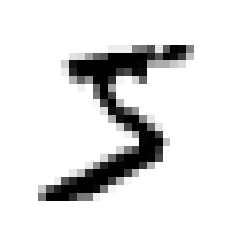

In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
y[0]

y[0] is a string. Most ML algorithms expect numbers so we cast y to integer

In [19]:
y = y.astype(np.uint8)

MNIST dataset is already split in training and testing tests

In [21]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

We start by just training a classifier to recognize the number '5'

In [23]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

##  Training

In [24]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
sgd_clf.predict([some_digit])

array([ True])

## Performance

Let's check the cross-validation score for our binary classifier

In [38]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

A very high accuracy is found on all cross-validation folds. Let's try again with a classifier that simply classifies every sample as "not 5"

In [32]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [39]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Still >90% accuracy if we classify everything as not-5. This means that 90% of the test samples are not 5s. Let's verify that

In [59]:
not_fives = y_train[y_train_5 == 0]
print('Total samples:', len(y_train))
print('Not-5 samples:', len(not_fives))

Total samples: 60000
Not-5 samples: 54579


### Confusion Matrix

A confusion matrix counts the number of times instance of class A are classified as class B

In [60]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The rows represent the *actual* class and the columns represent the *predicted* class. Thus, the classsifier is predicting a large number of 5s and not-5s. An ideal classifier will have a diagonal confusion matrix. Pretending that we reach perfection:

In [63]:
y_train_prefect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_prefect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### Precision and Recall

In [67]:
from sklearn.metrics import precision_score, recall_score
print('Precision:', precision_score(y_train_5, y_train_predict))
print('Recall:', recall_score(y_train_5, y_train_predict))

Precision: 0.8370879772350012
Recall: 0.6511713705958311


The precision implies that when the classifier claims an image to represent a 5, it is correct only 83.7% of the time.
Recall implies that the classifier only detects 65.1% of the 5s

We can combine the precision and recall to a single F1 score

In [68]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_predict)

0.7325171197343846

The F1 score prefers similar precision and recall. This is not preferred in all cases. Some times we might require high precision and some times high recall is desired. We can not increase both Precision and Recall either. There is a trade-off. Increasing precision decrease recall. Let's see that in action.

First we make the classifier return the score for each instance instead of prediction. The classifier internally thresholds this score to make a prediction

In [69]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [87]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

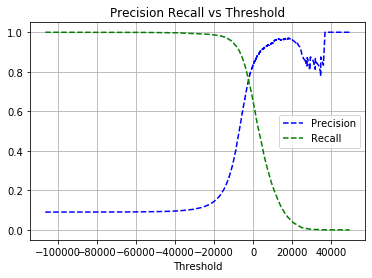

In [93]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.title('Precision Recall vs Threshold')
    plt.grid('on')
    plt.legend()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

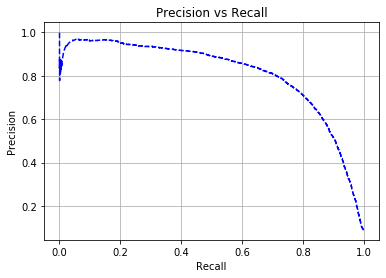

In [92]:
plt.plot(recalls[:-1], precisions[:-1], 'b--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.grid('on')
plt.show()

Let's try to pick a custom precision recall we might want for our project. Say, we want a precision of 90%. We need to find the threshold that gives us that

In [103]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [104]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [106]:
print('Precision:', precision_score(y_train_5, y_train_pred_90))
print('Recall:', recall_score(y_train_5, y_train_pred_90))

Precision: 0.9000345901072293
Recall: 0.4799852425751706


### ROC Curve
Receiver Operating Characteristics curve plots the true-positive rate (TPR) against the fall-positive rate (FPR)

In [107]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [114]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve')
    plt.grid('on')

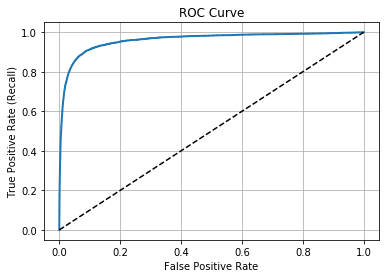

In [115]:
_ = plot_roc_curve(fpr, tpr)

The dotted line represents the ROC curve of a purely random classifier. Thus, the ROC curve should stay as far away from it as possible

To compare classifiers, we can measure the ROC area under the curve (AUC). A perfect classifier will have a ROC AUC of 1. A purely random classifier will have a value of 0.5.

In [116]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

But the ROC curve and the Precision vs Recall curve graph are similar, we have to choose one of them to compare the classifiers. As a rule of thumb, prefer the Precision vs Recall curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve.

In our case, our positive cases (5s) are few so we look at the Precision/Recall curve and for the recall of 0.65 we see that the classifier has room for improvement.

## Random Forest Classifier

In [131]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_5)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [143]:
cross_val_score(forest_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.98885, 0.9863 , 0.98635])

In [134]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_train_predict_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [136]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

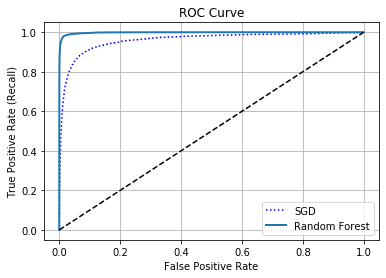

In [137]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [138]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

The Random Forest's ROC curve is much better than the SGD classifier

### Precision and Recall

In [139]:
from sklearn.metrics import precision_score, recall_score
print('Precision:', precision_score(y_train_5, y_train_predict_forest))
print('Recall:', recall_score(y_train_5, y_train_predict_forest))

Precision: 0.9905083315756169
Recall: 0.8662608374838591


In [140]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

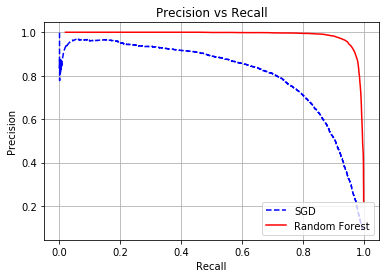

In [141]:
plt.plot(recalls[:-1], precisions[:-1], 'b--', label='SGD')
plt.plot(recalls_forest[:-1], precisions_forest[:-1], 'r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs Recall')
plt.grid('on')
plt.legend(loc='lower right')
plt.show()

Thus, the Random Forest classifier is much better than the SGD classifier